In [31]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF


from torch.utils.tensorboard import SummaryWriter
from mean_average_precision import MetricBuilder


from wsddn import *

In [78]:
train_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data', image_set='train', download=False)

In [79]:
img, label, boxes = train_set[2]

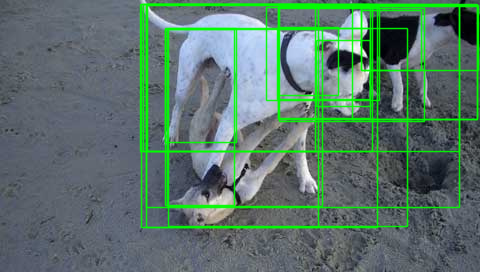

In [80]:
train_set.draw_raw_boxes(img, boxes)

In [81]:
boxes

tensor([[278.,   7., 370., 118.],
        [361.,  10., 421.,  70.],
        [361.,   5., 478.,  70.],
        [146.,   5., 459., 207.],
        [140.,   4., 315., 151.],
        [146.,   4., 377., 227.],
        [278.,   6., 477., 119.],
        [147.,   4., 372., 151.],
        [141.,   4., 318., 227.],
        [279.,   8., 424., 121.],
        [165.,  29., 234., 205.],
        [352.,   4., 477., 119.],
        [277.,  28., 370.,  99.],
        [278.,  27., 338.,  95.],
        [167.,  29., 322., 206.],
        [143.,   4., 459., 151.],
        [316.,  40., 370., 106.],
        [168.,  28., 407., 226.],
        [165.,  28., 236., 142.],
        [266.,   7., 379., 100.]])

In [97]:
# PIL case
torch.tensor(img.size) / 2.

tensor([240., 136.])

In [95]:
# Tensor case
img_t = transforms.ToTensor()(img)
torch.tensor(img_t.shape[1:]).flip(0) / 2.

tensor([240., 136.])

In [104]:
img_center = torch.tensor(img.size) / 2.
img_center = torch.tensor(np.hstack((img_center, img_center)))

In [105]:
boxes[:, [0, 2]] += 2*(img_center[[0, 2]] - boxes[:, [0, 2]])
box_w = torch.abs(boxes[:, 0] - boxes[:, 2])
boxes[:, 0] -= box_w
boxes[:, 2] += box_w

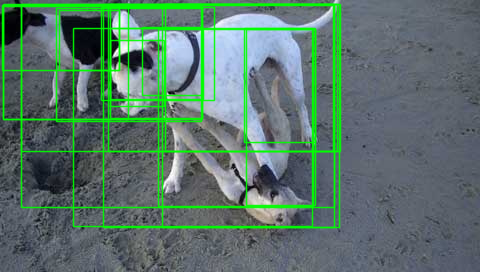

In [106]:
train_set.draw_raw_boxes(TF.hflip(img), boxes)

In [126]:
class BoxAndImageFlip(object):
    def __init__(self, p_horiz=0.5, p_vert=0.1):
        self.p_horiz = p_horiz
        self.p_vert = p_vert
    
    def __call__(self, image, boxes):
        # Horizontal flip
        if np.random.rand() < self.p_horiz:
            if isinstance(image, torch.Tensor):
                img_center = torch.tensor(image.shape[1:]).flip(0) / 2.
            else:
                # PIL
                img_center = torch.tensor(img.size) / 2.

            img_center = torch.tensor(np.hstack((img_center, img_center)))
            boxes[:, [0, 2]] += 2*(img_center[[0, 2]] - boxes[:, [0, 2]])
            box_w = torch.abs(boxes[:, 0] - boxes[:, 2])
            boxes[:, 0] -= box_w
            boxes[:, 2] += box_w

            image = TF.hflip(image)
        
        return image, boxes

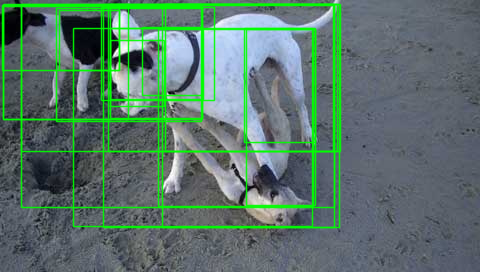

In [135]:
img, label, boxes = train_set[2]
img, boxes = BoxAndImageFlip(p_horiz=1)(img, boxes)
train_set.draw_raw_boxes(img, boxes)

In [136]:
class CustomVOC(datasets.VOCDetection):
    """Custom dataset that also generates boxes for each image"""
    def __init__(self, edge_model, eval_mode=False, new_boxes=False, augmentation=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_mode = eval_mode
        self.augmentation = augmentation
        if new_boxes:
            self.edge_boxes = EdgeBoxes(edge_model, max_boxes=20)
        else:
            self.edge_boxes = None

        self.label_names = [
                    'background',
                    'aeroplane',
                    'bicycle',
                    'bird',
                    'boat',
                    'bottle',
                    'bus',
                    'car',
                    'cat',
                    'chair',
                    'cow',
                    'diningtable',
                    'dog',
                    'horse',
                    'motorbike',
                    'person',
                    'pottedplant',
                    'sheep',
                    'sofa',
                    'train',
                    'tvmonitor'
                ]
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        
        if self.edge_boxes is None:
            edge_boxes = label['annotation']['edge_box']['bndbox']
            boxes = np.zeros((len(edge_boxes), 4))
            for i, box in enumerate(edge_boxes):
                boxes[i] = np.array([box['xmin'], box['ymin'], box['xmax'], box['ymax']])
        else:
            boxes = self.edge_boxes(image)

        boxes = transforms.ToTensor()(boxes.astype('float32')).view([len(boxes), 4])

        if self.augmentation is not None:
            image, boxes = self.augmentation(image, boxes)

        one_hot_label = torch.zeros(len(self.label_names))
        # one_hot_label = torch.ones(len(self.label_names)) * -1
        for obj in label['annotation']['object']:
            one_hot_label[self.label_names.index(obj['name'])] = 1

        if torch.sum(one_hot_label) == -len(self.label_names):
            # Background
            one_hot_label[0] = 1


        if self.eval_mode:
            gt_boxes = []
            for obj in label['annotation']['object']:
                label_index = self.label_names.index(obj['name'])
                bbox = obj['bndbox']
                gt_boxes.append([
                    int(bbox['xmin']), 
                    int(bbox['ymin']), 
                    int(bbox['xmax']), 
                    int(bbox['ymax']), 
                    label_index, 
                    int(obj['difficult']), 
                    0
                ])

            return image, one_hot_label, boxes, gt_boxes

        return image, one_hot_label, boxes


    def format_pred(self, net_detections):
        """net_detections: the output of WSDDN.detect()"""
        boxes = []
        for label in net_detections.keys():
            for box in net_detections[label]:
                boxes.append([*box[1], label, box[0]])
        
        return boxes


    def draw_boxes(self, image, pred_boxes, gt_boxes, thresh=0.6):
        """
        GT: [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
        Pred: [xmin, ymin, xmax, ymax, class_id, confidence]
        """
        img = image
        if not isinstance(image, torch.Tensor):
            img = transforms.PILToTensor()(image)

        img = img.permute((1,2,0)).numpy()

        for b in pred_boxes:
            x1, y1, x2, y2, class_id, conf = b
            if conf < thresh:
                continue
            img = cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (255, 0, 0))

        for b in gt_boxes:
            x1, y1, x2, y2, class_id, _, _ = b
            img = cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (0, 255, 0))

        return Image.fromarray(img)
    
    def draw_label(self, img, label, x1, y1, color):
        (label_width, label_height), baseline = cv.getTextSize(label, cv.FONT_HERSHEY_COMPLEX, 0.4, 1)
        back_tl = int(x1), int(y1 - int(1.3 * label_height))
        back_br = int(x1 + label_width), int(y1)
        cv.rectangle(img, back_tl, back_br, color, -1)
        txt_tl = int(x1), int(y1 - int(0.3 * label_height))
        return cv.putText(img, label, txt_tl, cv.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0))


    def draw_raw_boxes(self, image, boxes):
        cv_img_drawn = transforms.PILToTensor()(image)
        cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
        for i, b in enumerate(boxes):
            x1, y1, x2, y2 = b
            cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)

        return Image.fromarray(cv_img_drawn)


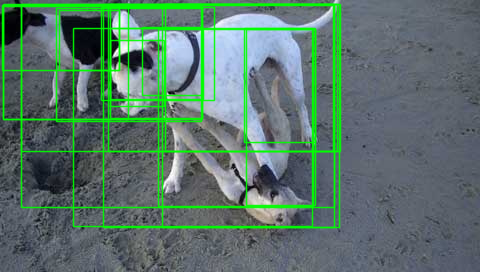

In [138]:
train_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data', image_set='train', download=False, augmentation=BoxAndImageFlip(p_horiz=1))
img, label, boxes = train_set[2]
train_set.draw_raw_boxes(img, boxes)

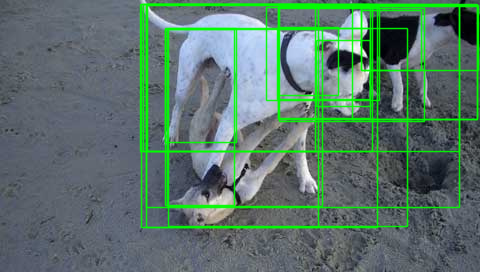

In [141]:
train_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data', image_set='train', download=False, augmentation=BoxAndImageFlip(p_horiz=0.5))
img, label, boxes = train_set[2]
train_set.draw_raw_boxes(img, boxes)